In [1]:
%%capture
!pip install yfinance

# Mean Reversion Trading Stratedy 
## 

In [2]:
import pandas as pd

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance
import yfinance as yf

# Fetch daily data for 4 years
ticker='GOOG'
start_date = '2018-01-01'
end_date = '2021-12-31'

df = yf.download(ticker, start_date, end_date)


module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


# Variables/constants for EMA Calculation:
### Choose slow moving time period as 40 days, fast moving time period as 10 days

In [3]:
num_of_periods_fast=10 # Static time period parameter for the fast EMA
lam_fast=2.0/(num_of_periods_fast+1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

num_of_periods_slow=40 # Static time period parameter for slow EMA
lam_slow=2.0/(num_of_periods_slow+1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals


## Variables for Trading Strategy trade, position & pnl management:

In [4]:

orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far


In [5]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600


# Constants that define strategy behavior/thresholds
- apo_value_for_buy_entry = -10 # APO trading signal value below which to enter buy-orders/long-position
- apo_value_for_sell_entry = 10 # APO trading signal value above which to enter sell-orders/short-position
- min_price_move_from_last_trade = 10 # Minimum price change since last trade before considering trading again,  
- num_shares_per_trade = 10 # Number of shares to buy/sell on every trade
- min_profit_to_close = 10*num_shares_per_trade # Minimum Open/Unrealized profit at which to close positions and lock profits


In [6]:
apo_value_for_buy_entry = -10 # APO trading signal value below which to enter buy-orders/long-position
apo_value_for_sell_entry = 10 # APO trading signal value above which to enter sell-orders/short-position
min_price_move_from_last_trade = 10 # Minimum price change since last trade before considering trading again, 
                                    # this is to prevent over-trading at/around same prices
                                    # we may set this as a % of last traded price
num_shares_per_trade = 10 # Number of shares to buy/sell on every trade
min_profit_to_close = 10*num_shares_per_trade # Minimum Open/Unrealized profit at which to close positions and lock profits


## Set up the buy/sell strategy as well as the exit strategy

In [7]:
#use closing price
i=0
close=df['Adj Close']
for close_price in close:
    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = close_price * lam_fast + (1-lam_fast)*ema_fast
        ema_slow = close_price * lam_slow + (1-lam_slow)*ema_slow
        
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
    apo = ema_fast - ema_slow
    apo_values.append(apo)

# Checks trading signal against trading parameters/thresholds and positions, to trade.

# We will perform a sell trade at close_price if the following conditions are met:
# 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
# 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    if ((apo > apo_value_for_sell_entry and abs(close_price - last_sell_price) > min_price_move_from_last_trade) # APO above sell entry threshold, we should sell
        or
        (position > 0 and (apo >= 0 or open_pnl > min_profit_to_close))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= num_shares_per_trade # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*num_shares_per_trade) # sell-price
        sell_sum_qty += num_shares_per_trade
        print( "Sell ", num_shares_per_trade, " @ ", close_price, "Position: ", position )
        print('The market on this day: ', df[i:i+1])
  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    elif ((apo < apo_value_for_buy_entry and abs(close_price - last_buy_price) > min_price_move_from_last_trade) # APO below buy entry threshold, we should buy
        or
        (position < 0 and (apo <= 0 or open_pnl > min_profit_to_close))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += num_shares_per_trade # increase position by the size of this trade
        buy_sum_price_qty += (close_price*num_shares_per_trade) # update the vwap buy-price
        buy_sum_qty += num_shares_per_trade
        print( "Buy ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
        print('The market on this day: ', df[i:i+1])
    else:
    # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

# This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)
    i+=1

Streaming output truncated to the last 5000 lines.
The market on this day:                     Open        High          Low       Close   Adj Close  \
Date                                                                       
2018-06-27  1121.339966  1131.83606  1103.619995  1103.97998  1103.97998   

             Volume  
Date                 
2018-06-27  1293900  
OpenPnL:  3401.9356282552076  ClosedPnL:  12266.8994140625  TotalPnL:  15668.835042317707
Sell  10  @  1114.219970703125 Position:  -70
The market on this day:                     Open         High         Low        Close    Adj Close  \
Date                                                                         
2018-06-28  1102.089966  1122.310059  1096.01001  1114.219971  1114.219971   

             Volume  
Date                 
2018-06-28  1072400  
OpenPnL:  2411.663085937514  ClosedPnL:  12266.8994140625  TotalPnL:  14678.562500000015
Buy  10  @  1115.6500244140625 Position:  -60
The market on this day:         

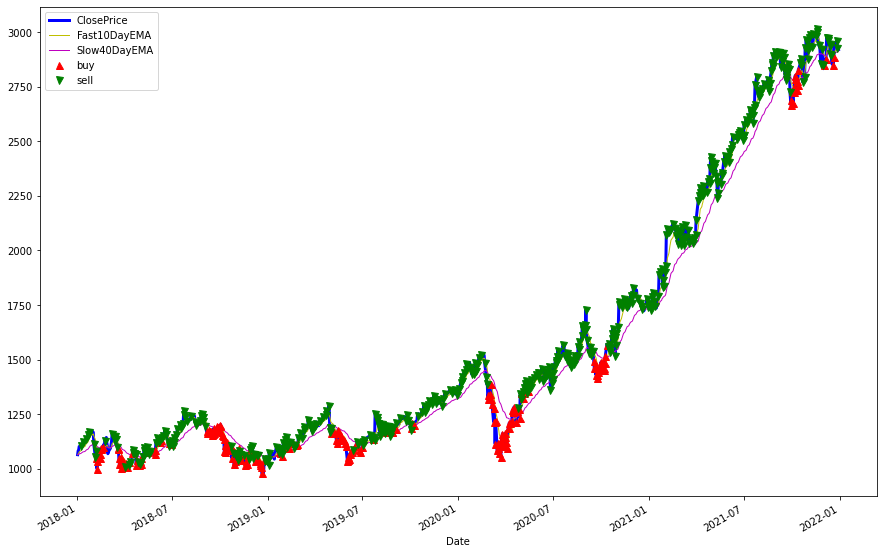

In [8]:
#Prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

import matplotlib.pyplot as plt

df['ClosePrice'].plot(color='blue', lw=3., legend=True, figsize=(15,10))
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True, figsize=(15,10))
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True, figsize=(15,10))
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.savefig('ClosePrice-Fast10DayEMA-Slow40DayEMA.jpg')
plt.show()



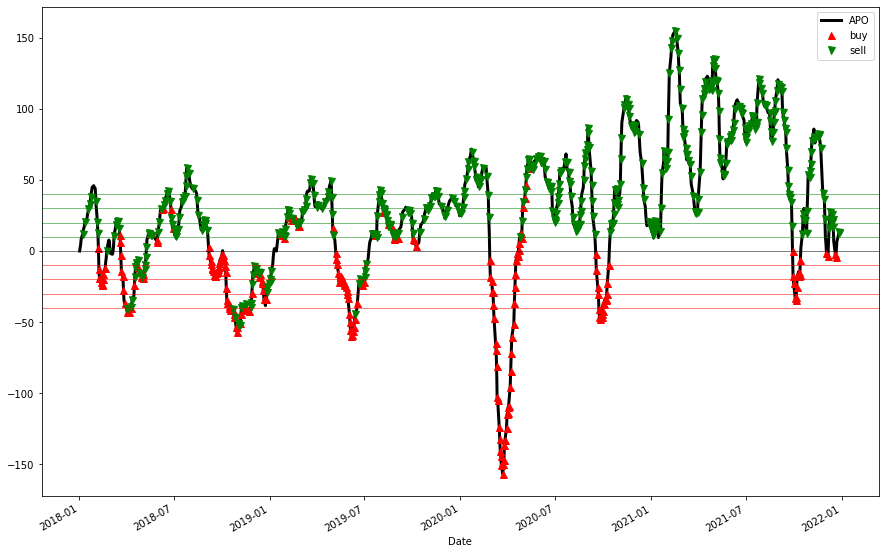

In [9]:
df['APO'].plot(color='k', lw=3., legend=True, figsize=(15,10))
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], \
         color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], \
         color='g', lw=0, marker='v', markersize=7, label='sell', )
plt.axhline(y=0, lw=0.5, color='k')
for i in range( apo_value_for_buy_entry, apo_value_for_buy_entry*5, apo_value_for_buy_entry ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( apo_value_for_sell_entry, apo_value_for_sell_entry*5, apo_value_for_sell_entry ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()



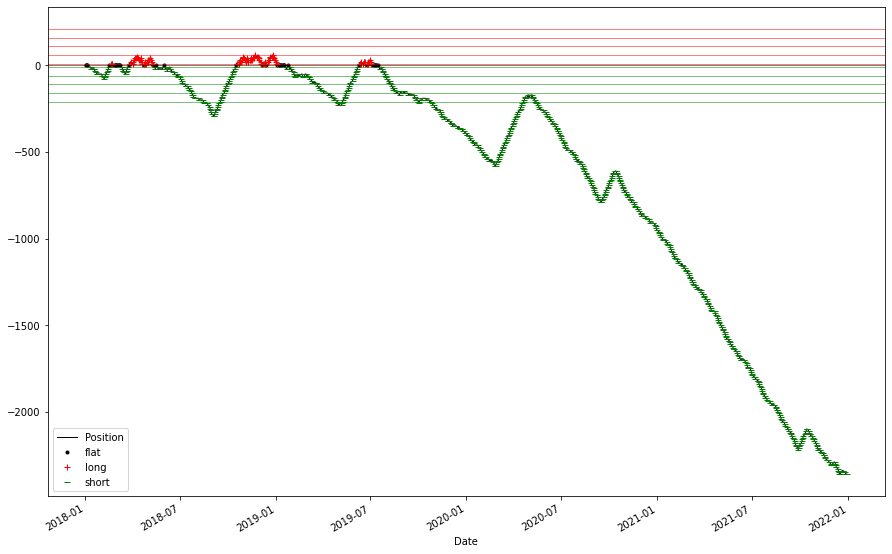

In [10]:
df['Position'].plot(color='k', lw=1., legend=True, figsize=(15,10))
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], \
         color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], \
         color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], \
         color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( num_shares_per_trade, num_shares_per_trade*25, num_shares_per_trade*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -num_shares_per_trade, -num_shares_per_trade*25, -num_shares_per_trade*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.savefig('Long-Shot-Position')
plt.show()



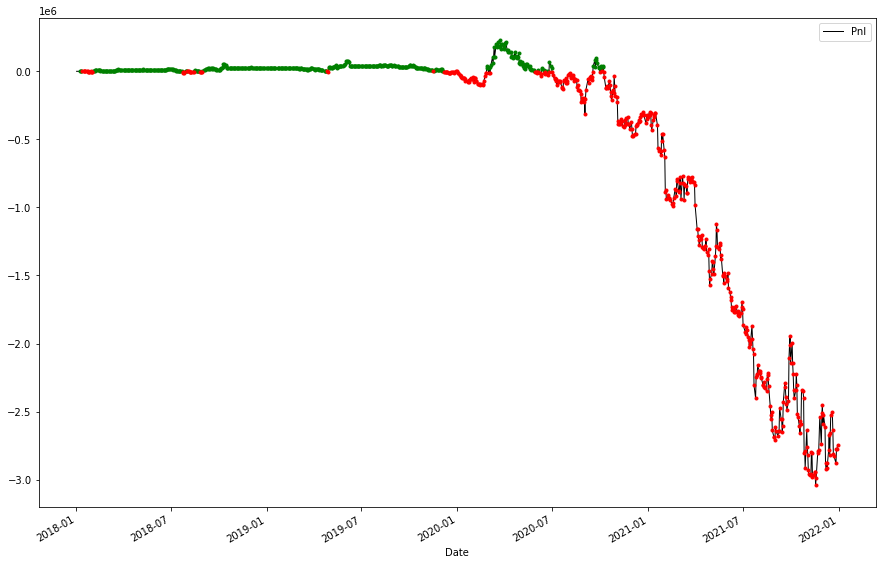

-2743519.099877481


In [11]:
df['Pnl'].plot(color='k', lw=1., legend=True, figsize=(15,10))
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.savefig('APO-P&L.jpg')
plt.show()

print(df['Pnl'][-1])
df.to_csv("basic_mean_reversion.csv", sep=",")

It doesn't work (at least for this case)